In [1]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt
 
import zipfile
import requests
import glob as glob
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory
 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

2023-07-03 05:28:54.606073: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 05:28:54.608790: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 05:28:54.647316: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 05:28:54.647839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 05:28:55.645369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
SEED_VALUE = 41
 
# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 43
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
         
    DATA_ROOT_TRAIN:  str = './dataset_traffic_signs_40_samples_per_class/Train' 
    DATA_ROOT_VALID:  str = './dataset_traffic_signs_40_samples_per_class/Valid'
    DATA_ROOT_TEST:   str = './dataset_traffic_signs_40_samples_per_class/Test'
    DATA_TEST_GT:     str = './dataset_traffic_signs_40_samples_per_class/Test.csv'
         
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 1
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8   

In [4]:
train_dataset = image_dataset_from_directory(directory='CyberbullyingFormattedData/cyberbullying_data_splits_clean/test/',
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                             validation_split=0.2,  # Split 20% of the data for validation
                                             subset='training',
                                            )

valid_dataset = image_dataset_from_directory(directory='CyberbullyingFormattedData/cyberbullying_data_splits_clean/test/',
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                             validation_split=0.2,  # Split 20% of the data for validation
                                             subset='validation',
                                            )

Found 3873 files belonging to 2 classes.
Using 3099 files for training.
Found 3873 files belonging to 2 classes.
Using 774 files for validation.


2023-07-03 05:29:04.434583: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
print(train_dataset.class_names)

['cyberbullying', 'non_cyberbullying']


2023-07-03 05:29:10.618536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3099]
	 [[{{node Placeholder/_0}}]]
2023-07-03 05:29:10.618781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3099]
	 [[{{node Placeholder/_4}}]]
2023-07-03 05:29:10.677016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


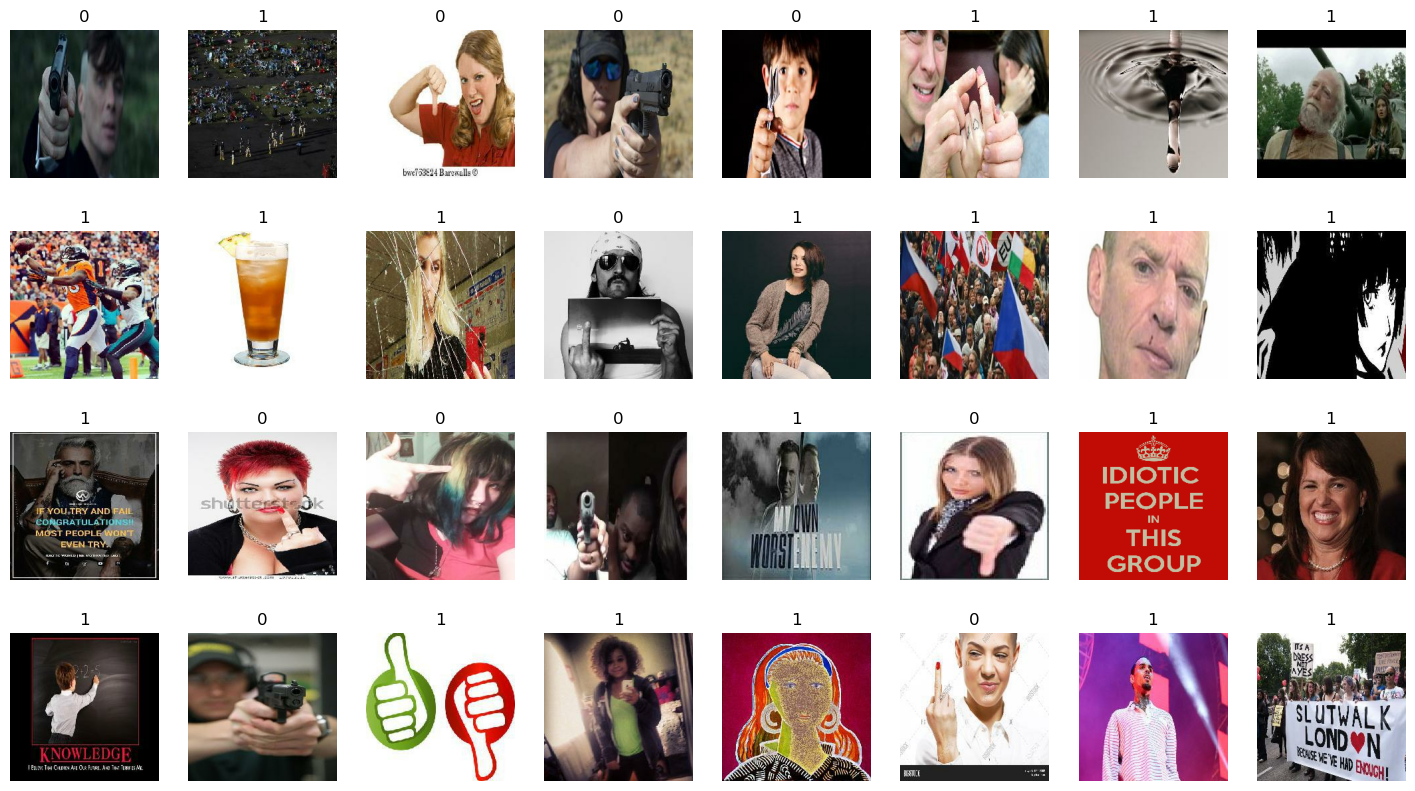

In [6]:
class_names = train_dataset.class_names
 
plt.figure(figsize=(18,10))
 
# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8
 
# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
      
    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(truth_idx)
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_dataset.take(1): 
    print(labels_batch[3])

tf.Tensor(0, shape=(), dtype=int32)


2023-07-03 05:29:35.639704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3099]
	 [[{{node Placeholder/_4}}]]
2023-07-03 05:29:35.639947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3099]
	 [[{{node Placeholder/_4}}]]
2023-07-03 05:29:35.669059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [8]:
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )

In [9]:
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
 
print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
# print(vgg16_conv_base.summary())

Loading model with ImageNet weights...


In [12]:
vgg16_conv_base.trainable = True
 
# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)
 
# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False
 
print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")
     
# print(vgg16_conv_base.summary())

FREEZING LAYER: <keras.engine.input_layer.InputLayer object at 0x155094b8d640>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x155094b87880>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x1550955400a0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x155094bafdc0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x1550954e4910>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x155094b34f40>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x155094b34fd0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x155094b8d550>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x15509551af40>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x155094b39eb0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x155094b45f40>


Configured to fine tune the last 8 convolutional layers...

In [13]:
inputs = tf.keras.Input(shape=input_shape)
     
x = tf.keras.applications.vgg16.preprocess_input(inputs)
     
x = vgg16_conv_base(x)
 
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)
     
# The final `Dense` layer with the number of classes.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
     
# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)
 
print(model_vgg16_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                             

In [14]:
model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [15]:
training_results = model_vgg16_finetune.fit(train_dataset,
                                            epochs=20,
                                            validation_data=valid_dataset,
                                           )

Epoch 1/20


2023-07-03 05:30:21.836635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3099]
	 [[{{node Placeholder/_4}}]]
2023-07-03 05:30:21.836856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3099]
	 [[{{node Placeholder/_0}}]]
2023-07-03 05:30:22.895157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 2.7283 - accuracy: 0.5913

2023-07-03 05:30:54.032222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 2.2401 - accuracy: 0.6275

2023-07-03 05:31:04.551026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 2.0658 - accuracy: 0.6422

2023-07-03 05:31:10.338096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 1.8298 - accuracy: 0.6616

2023-07-03 05:31:20.108270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 1.7405 - accuracy: 0.6678

2023-07-03 05:31:25.147768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 1.6604 - accuracy: 0.6723

2023-07-03 05:31:30.100439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 1.5131 - accuracy: 0.6789

2023-07-03 05:31:42.218493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [774]
	 [[{{node Placeholder/_0}}]]
2023-07-03 05:31:42.218742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [774]
	 [[{{node Placeholder/_0}}]]
2023-07-03 05:31:42.408768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:31:43.260735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:31:43.711048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: i

97/97 [==============================] - 91s 927ms/step - loss: 1.5131 - accuracy: 0.6789 - val_loss: 0.4471 - val_accuracy: 0.8075
Epoch 2/20


2023-07-03 05:31:52.765977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.6012 - accuracy: 0.7730

2023-07-03 05:32:23.833266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.5691 - accuracy: 0.7855

2023-07-03 05:32:34.492713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.5737 - accuracy: 0.7839

2023-07-03 05:32:40.208398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.5610 - accuracy: 0.7933

2023-07-03 05:32:50.071758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.5535 - accuracy: 0.7932

2023-07-03 05:32:54.973795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.5525 - accuracy: 0.7919

2023-07-03 05:32:59.991411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7874

2023-07-03 05:33:12.079724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:33:12.980898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:33:13.407106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 926ms/step - loss: 0.5625 - accuracy: 0.7874 - val_loss: 0.3799 - val_accuracy: 0.8475
Epoch 3/20


2023-07-03 05:33:22.507878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.5674 - accuracy: 0.7829

2023-07-03 05:33:53.814596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.5427 - accuracy: 0.7904

2023-07-03 05:34:04.481555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 32s - loss: 0.5421 - accuracy: 0.7883

2023-07-03 05:34:10.238385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.5278 - accuracy: 0.7951

2023-07-03 05:34:20.037335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.5123 - accuracy: 0.7998

2023-07-03 05:34:24.911246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.5119 - accuracy: 0.8011

2023-07-03 05:34:29.854724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.8032

2023-07-03 05:34:42.044753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:34:42.900979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:34:43.331788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 928ms/step - loss: 0.5069 - accuracy: 0.8032 - val_loss: 0.3802 - val_accuracy: 0.8411
Epoch 4/20


2023-07-03 05:34:52.504581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.4037 - accuracy: 0.8413

2023-07-03 05:35:23.490100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.3801 - accuracy: 0.8517

2023-07-03 05:35:34.061137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.3793 - accuracy: 0.8567

2023-07-03 05:35:39.683549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 21s - loss: 0.3823 - accuracy: 0.8562

2023-07-03 05:35:49.470460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.3794 - accuracy: 0.8581

2023-07-03 05:35:54.459231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.3769 - accuracy: 0.8594

2023-07-03 05:35:59.303673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8616

2023-07-03 05:36:11.405932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:36:12.225276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:36:12.665473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 89s 922ms/step - loss: 0.3661 - accuracy: 0.8616 - val_loss: 0.3942 - val_accuracy: 0.8553
Epoch 5/20


2023-07-03 05:36:21.835713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.3549 - accuracy: 0.8742

2023-07-03 05:36:53.112838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.3215 - accuracy: 0.8824

2023-07-03 05:37:03.829805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 32s - loss: 0.3156 - accuracy: 0.8831

2023-07-03 05:37:09.558664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.3076 - accuracy: 0.8866

2023-07-03 05:37:19.431637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.3042 - accuracy: 0.8886

2023-07-03 05:37:24.292903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.2983 - accuracy: 0.8902

2023-07-03 05:37:29.196635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8951

2023-07-03 05:37:41.346327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:37:42.197560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:37:42.663886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 927ms/step - loss: 0.2872 - accuracy: 0.8951 - val_loss: 0.4210 - val_accuracy: 0.8475
Epoch 6/20


2023-07-03 05:37:51.751675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.2479 - accuracy: 0.9095

2023-07-03 05:38:22.989044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.2351 - accuracy: 0.9118

2023-07-03 05:38:33.518221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.2311 - accuracy: 0.9138

2023-07-03 05:38:39.167915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.2238 - accuracy: 0.9147

2023-07-03 05:38:49.041012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.2208 - accuracy: 0.9174

2023-07-03 05:38:53.955962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.2244 - accuracy: 0.9165

2023-07-03 05:38:58.834930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9138

2023-07-03 05:39:11.053031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:39:11.875240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:39:12.323928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 926ms/step - loss: 0.2254 - accuracy: 0.9138 - val_loss: 0.6466 - val_accuracy: 0.7959
Epoch 7/20


2023-07-03 05:39:21.510914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 47s - loss: 0.2218 - accuracy: 0.9194

2023-07-03 05:39:52.311755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.2167 - accuracy: 0.9203

2023-07-03 05:40:02.917837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.2127 - accuracy: 0.9235

2023-07-03 05:40:08.761820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.1996 - accuracy: 0.9286

2023-07-03 05:40:18.663985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.1918 - accuracy: 0.9317

2023-07-03 05:40:23.354928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.1862 - accuracy: 0.9337

2023-07-03 05:40:28.341915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.9361

2023-07-03 05:40:40.511126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:40:41.360659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:40:41.771159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 89s 921ms/step - loss: 0.1790 - accuracy: 0.9361 - val_loss: 0.5175 - val_accuracy: 0.8463
Epoch 8/20


2023-07-03 05:40:50.723464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.1427 - accuracy: 0.9498

2023-07-03 05:41:22.009594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.1390 - accuracy: 0.9504

2023-07-03 05:41:32.761665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 32s - loss: 0.1357 - accuracy: 0.9526

2023-07-03 05:41:38.467816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.1350 - accuracy: 0.9522

2023-07-03 05:41:48.287514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.1377 - accuracy: 0.9515

2023-07-03 05:41:53.243950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.1385 - accuracy: 0.9516

2023-07-03 05:41:58.061884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9519

2023-07-03 05:42:10.223754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:42:11.039336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:42:11.466897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 927ms/step - loss: 0.1373 - accuracy: 0.9519 - val_loss: 0.4716 - val_accuracy: 0.8915
Epoch 9/20


2023-07-03 05:42:20.583195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 47s - loss: 0.0822 - accuracy: 0.9720

2023-07-03 05:42:51.451657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0912 - accuracy: 0.9681

2023-07-03 05:43:02.057923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.0917 - accuracy: 0.9688

2023-07-03 05:43:07.842660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 21s - loss: 0.0886 - accuracy: 0.9714

2023-07-03 05:43:17.551862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0875 - accuracy: 0.9716

2023-07-03 05:43:22.519914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0860 - accuracy: 0.9722

2023-07-03 05:43:27.355911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9687

2023-07-03 05:43:39.326725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:43:40.163962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:43:40.587203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 89s 917ms/step - loss: 0.0924 - accuracy: 0.9687 - val_loss: 0.4610 - val_accuracy: 0.8527
Epoch 10/20


2023-07-03 05:43:49.424923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.0882 - accuracy: 0.9671

2023-07-03 05:44:20.472959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0813 - accuracy: 0.9700

2023-07-03 05:44:31.124123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.0767 - accuracy: 0.9720

2023-07-03 05:44:36.998236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.0816 - accuracy: 0.9705

2023-07-03 05:44:46.821818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0832 - accuracy: 0.9700

2023-07-03 05:44:51.670597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0860 - accuracy: 0.9684

2023-07-03 05:44:56.630562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9658

2023-07-03 05:45:08.708316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:45:09.544624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:45:09.942728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 89s 923ms/step - loss: 0.0916 - accuracy: 0.9658 - val_loss: 0.6851 - val_accuracy: 0.8734
Epoch 11/20


2023-07-03 05:45:18.890048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.1852 - accuracy: 0.9367

2023-07-03 05:45:50.222419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.1728 - accuracy: 0.9424

2023-07-03 05:46:00.823866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 32s - loss: 0.1638 - accuracy: 0.9461

2023-07-03 05:46:06.602669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.1473 - accuracy: 0.9504

2023-07-03 05:46:16.456308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.1495 - accuracy: 0.9515

2023-07-03 05:46:21.375866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.1460 - accuracy: 0.9524

2023-07-03 05:46:26.254318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9519

2023-07-03 05:46:38.449167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:46:39.289429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:46:39.682684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 929ms/step - loss: 0.1477 - accuracy: 0.9519 - val_loss: 0.4902 - val_accuracy: 0.8605
Epoch 12/20


2023-07-03 05:46:48.922235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.0993 - accuracy: 0.9679

2023-07-03 05:47:19.966889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0895 - accuracy: 0.9706

2023-07-03 05:47:30.793493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 32s - loss: 0.0847 - accuracy: 0.9731

2023-07-03 05:47:36.645731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.0774 - accuracy: 0.9759

2023-07-03 05:47:46.380583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0753 - accuracy: 0.9766

2023-07-03 05:47:51.302761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0762 - accuracy: 0.9745

2023-07-03 05:47:56.201450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9748

2023-07-03 05:48:08.274382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:48:09.084263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:48:09.490304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 924ms/step - loss: 0.0763 - accuracy: 0.9748 - val_loss: 0.6994 - val_accuracy: 0.8579
Epoch 13/20


2023-07-03 05:48:18.465433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 47s - loss: 0.0418 - accuracy: 0.9885

2023-07-03 05:48:49.367362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0397 - accuracy: 0.9884

2023-07-03 05:49:00.063307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.0373 - accuracy: 0.9892

2023-07-03 05:49:05.771804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.0399 - accuracy: 0.9888

2023-07-03 05:49:15.567607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0384 - accuracy: 0.9893

2023-07-03 05:49:20.655418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0385 - accuracy: 0.9893

2023-07-03 05:49:25.616267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9894

2023-07-03 05:49:37.784164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:49:38.604817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:49:39.037779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 89s 923ms/step - loss: 0.0385 - accuracy: 0.9894 - val_loss: 0.7810 - val_accuracy: 0.8708
Epoch 14/20


2023-07-03 05:49:47.916558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.0389 - accuracy: 0.9901

2023-07-03 05:50:19.321699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0357 - accuracy: 0.9902

2023-07-03 05:50:30.007069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 32s - loss: 0.0331 - accuracy: 0.9914

2023-07-03 05:50:35.765158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.0296 - accuracy: 0.9924

2023-07-03 05:50:45.465548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0297 - accuracy: 0.9922

2023-07-03 05:50:50.380200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0287 - accuracy: 0.9924

2023-07-03 05:50:55.316029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9910

2023-07-03 05:51:07.542351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:51:08.362750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:51:08.793528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 928ms/step - loss: 0.0312 - accuracy: 0.9910 - val_loss: 0.7493 - val_accuracy: 0.8566
Epoch 15/20


2023-07-03 05:51:17.814137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 49s - loss: 0.0397 - accuracy: 0.9860

2023-07-03 05:51:49.401207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0380 - accuracy: 0.9859

2023-07-03 05:51:59.935821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 32s - loss: 0.0381 - accuracy: 0.9860

2023-07-03 05:52:05.713753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.0519 - accuracy: 0.9830

2023-07-03 05:52:15.449105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0539 - accuracy: 0.9815

2023-07-03 05:52:20.469335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0552 - accuracy: 0.9798

2023-07-03 05:52:25.367442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9793

2023-07-03 05:52:37.444103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:52:38.306945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:52:38.725461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 928ms/step - loss: 0.0562 - accuracy: 0.9793 - val_loss: 0.7119 - val_accuracy: 0.8618
Epoch 16/20


2023-07-03 05:52:47.729290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 47s - loss: 0.0625 - accuracy: 0.9745

2023-07-03 05:53:18.616272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0714 - accuracy: 0.9755

2023-07-03 05:53:29.284193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.0761 - accuracy: 0.9741

2023-07-03 05:53:34.918652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 21s - loss: 0.0694 - accuracy: 0.9754

2023-07-03 05:53:44.720636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0689 - accuracy: 0.9757

2023-07-03 05:53:49.554073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0678 - accuracy: 0.9756

2023-07-03 05:53:54.508072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9781

2023-07-03 05:54:06.785130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:54:07.627362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:54:08.040478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 89s 922ms/step - loss: 0.0603 - accuracy: 0.9781 - val_loss: 0.7081 - val_accuracy: 0.8824
Epoch 17/20


2023-07-03 05:54:17.115905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.0302 - accuracy: 0.9926

2023-07-03 05:54:48.226285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0378 - accuracy: 0.9896

2023-07-03 05:54:58.573312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.0419 - accuracy: 0.9887

2023-07-03 05:55:04.340659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.0415 - accuracy: 0.9875

2023-07-03 05:55:14.260814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0460 - accuracy: 0.9864

2023-07-03 05:55:19.082875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0484 - accuracy: 0.9848

2023-07-03 05:55:24.160432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9845

2023-07-03 05:55:36.269655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:55:37.074447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:55:37.485916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 89s 923ms/step - loss: 0.0484 - accuracy: 0.9845 - val_loss: 0.6669 - val_accuracy: 0.8695
Epoch 18/20


2023-07-03 05:55:46.566023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.0309 - accuracy: 0.9893

2023-07-03 05:56:17.620760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0294 - accuracy: 0.9890

2023-07-03 05:56:28.322020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.0279 - accuracy: 0.9892

2023-07-03 05:56:34.114083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 22s - loss: 0.0271 - accuracy: 0.9902

2023-07-03 05:56:43.976404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0252 - accuracy: 0.9910

2023-07-03 05:56:48.906476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0247 - accuracy: 0.9912

2023-07-03 05:56:53.687234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9919

2023-07-03 05:57:05.874859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:57:06.806484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:57:07.250806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 90s 924ms/step - loss: 0.0234 - accuracy: 0.9919 - val_loss: 0.8171 - val_accuracy: 0.8618
Epoch 19/20


2023-07-03 05:57:16.161782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 48s - loss: 0.0328 - accuracy: 0.9893

2023-07-03 05:57:47.162738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0348 - accuracy: 0.9877

2023-07-03 05:57:57.757174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.0342 - accuracy: 0.9881

2023-07-03 05:58:03.365451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 21s - loss: 0.0397 - accuracy: 0.9862

2023-07-03 05:58:13.115428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0407 - accuracy: 0.9852

2023-07-03 05:58:17.944001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0433 - accuracy: 0.9836

2023-07-03 05:58:22.902121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9832

2023-07-03 05:58:34.991882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:58:35.842628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 05:58:36.257477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 89s 919ms/step - loss: 0.0469 - accuracy: 0.9832 - val_loss: 1.0044 - val_accuracy: 0.8049
Epoch 20/20


2023-07-03 05:58:45.216712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/97 [==========>...................] - ETA: 47s - loss: 0.0889 - accuracy: 0.9770

2023-07-03 05:59:16.049038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


51/97 [==============>...............] - ETA: 37s - loss: 0.0787 - accuracy: 0.9786

2023-07-03 05:59:26.511045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/97 [================>.............] - ETA: 31s - loss: 0.0721 - accuracy: 0.9806

2023-07-03 05:59:32.230439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


70/97 [====================>.........] - ETA: 21s - loss: 0.0688 - accuracy: 0.9808

2023-07-03 05:59:42.063034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


76/97 [======================>.......] - ETA: 17s - loss: 0.0658 - accuracy: 0.9819

2023-07-03 05:59:46.948833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


82/97 [========================>.....] - ETA: 12s - loss: 0.0650 - accuracy: 0.9809

2023-07-03 05:59:51.883673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9813

2023-07-03 06:00:04.193541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 06:00:05.036524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-03 06:00:05.477752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/97 [==============================] - 89s 923ms/step - loss: 0.0619 - accuracy: 0.9813 - val_loss: 0.6928 - val_accuracy: 0.8605


In [16]:
image_paths = sorted(glob.glob('test_dataset/test/cyberbullying' + '/*.jpg'))

In [17]:
label_ids = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]

In [18]:
print(len(image_paths))
print(len(label_ids))

15
15


In [19]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))

In [20]:
def preprocess_image(image):
    # Decode and resize image.
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT])
    return image

def load_and_preprocess_image(path):
    # Read image into memory as a byte string.
    image = tf.io.read_file(path)
    return preprocess_image(image)


def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

In [21]:
test_dataset = test_dataset.map(load_and_preprocess_from_path_label)
 
test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)

2023-07-03 06:03:33.772999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [15]
	 [[{{node Placeholder/_1}}]]


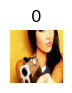

In [22]:
for image_batch, labels_batch in test_dataset.take(1): 
      
    # Plot each of the images in the batch and the associated ground truth labels.
    ax = plt.subplot(num_rows, num_cols, 1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    truth_idx = labels_batch[0].numpy()
    plt.title(truth_idx)
    plt.axis("off")

2023-07-03 06:03:39.723835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [15]
	 [[{{node Placeholder/_1}}]]


(15, 224, 224, 3)
1/1 [==============================] - 0s 343ms/step


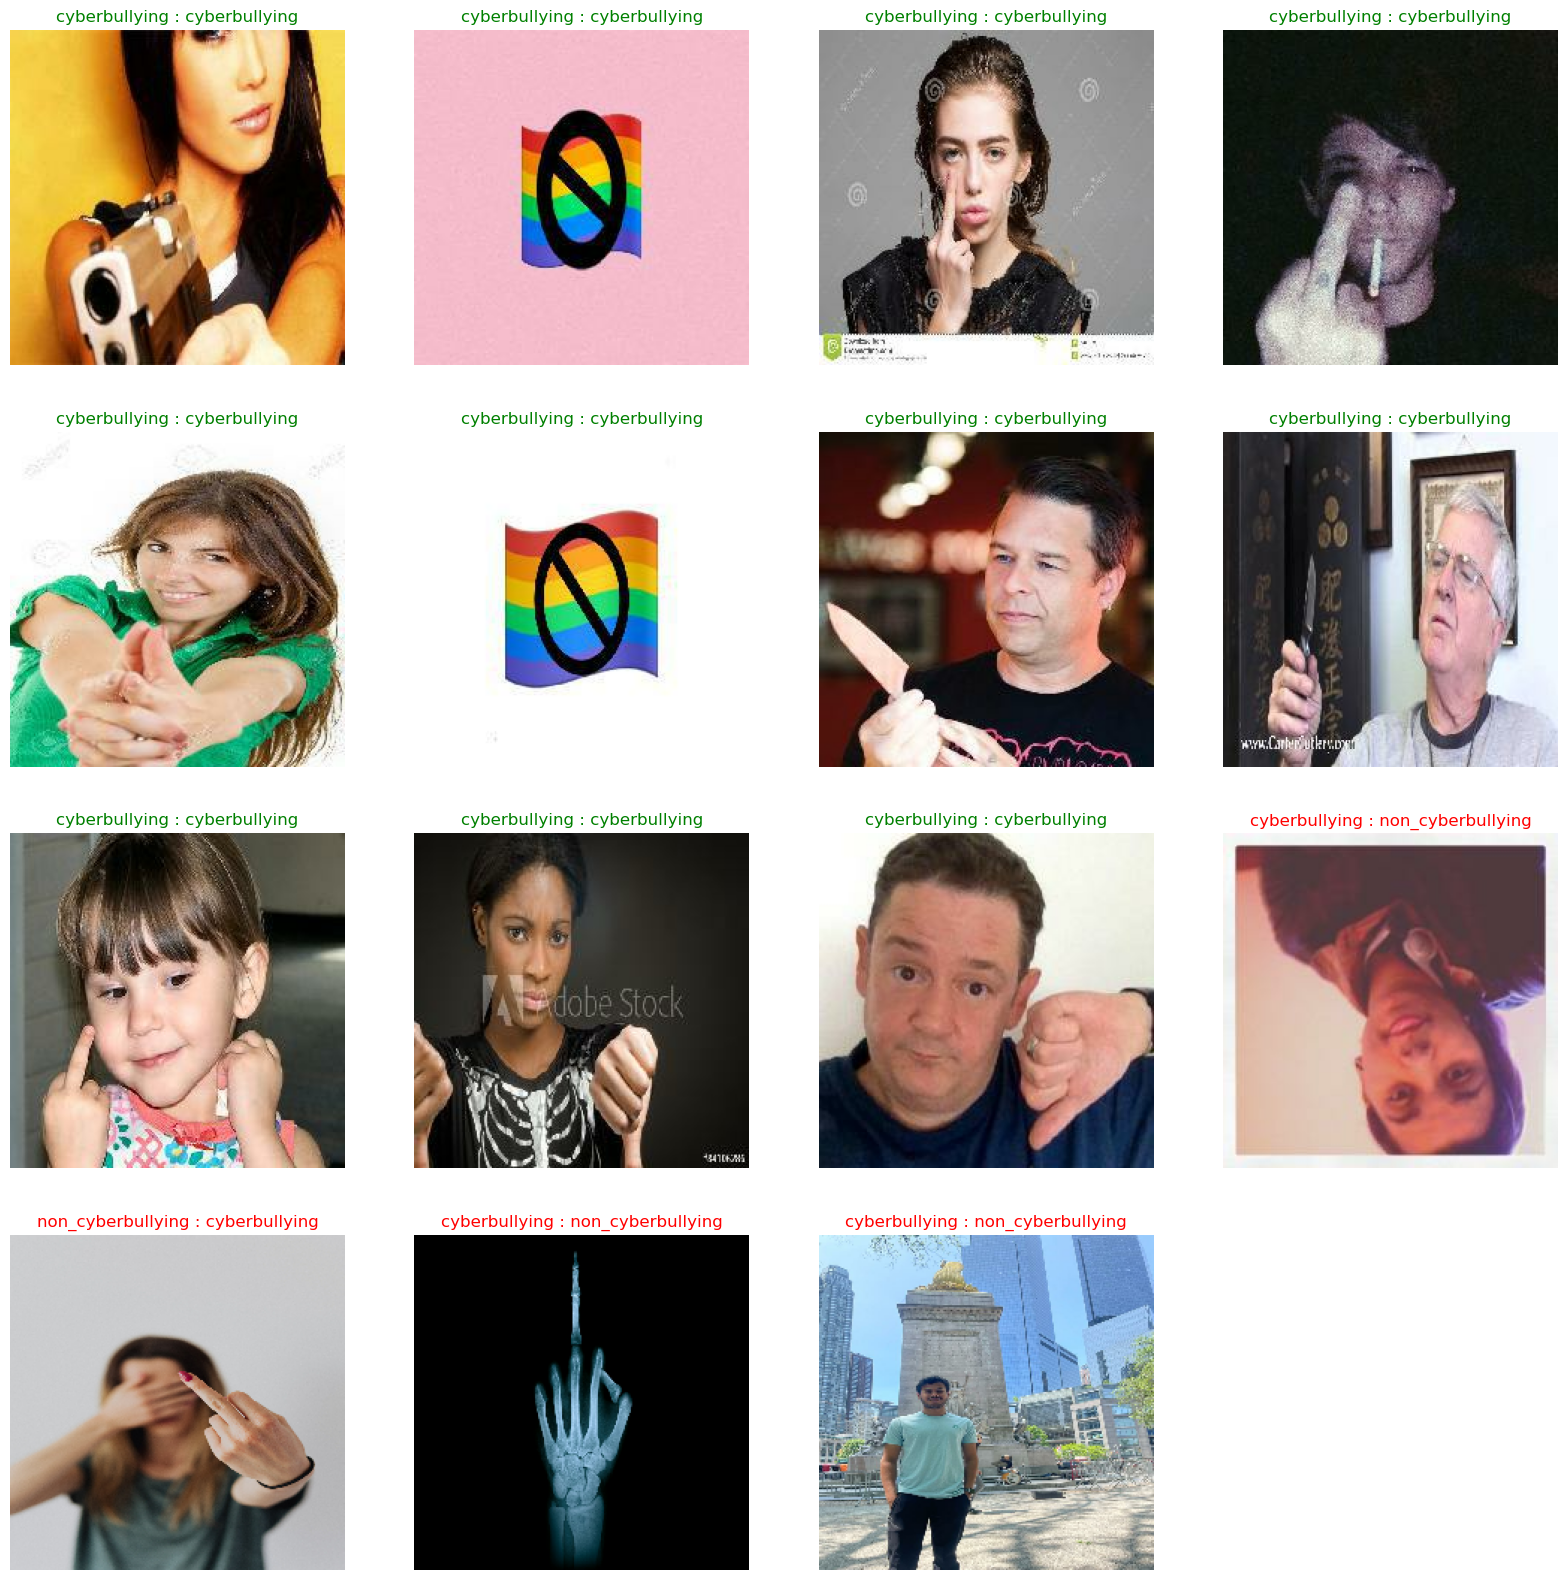

In [23]:
plt.figure(figsize=(20,20))
num_rows = 4
num_cols = 4
jdx = 0
model = model_vgg16_finetune

# Evaluate all the batches.
for image_batch, labels_batch in test_dataset.take(1):

    print(image_batch.shape)

    # Predictions for the current batch.
    predictions = model.predict(image_batch)

    # Loop over all the images in the current batch.
    for idx in range(len(labels_batch)):
        # print('id - ', idx)
        # print('pred - ', predictions[idx])
        pred_idx = tf.argmax(predictions[idx]).numpy()
        truth_idx = labels_batch[idx].numpy()

        # Set the title color based on the prediction.
        if pred_idx == truth_idx:
            color='g'
        else:
            color='r'

        jdx += 1

        if jdx > num_rows*num_cols:
            # Break from the loops if the maximum number of images have been plotted
            break

        ax = plt.subplot(num_rows, num_cols, jdx)
        title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])

        title_obj = plt.title(title)
        plt.setp(title_obj, color=color)
        plt.axis("off")
        plt.imshow(image_batch[idx].numpy().astype("uint8"));

In [24]:
model_vgg16_finetune.save('fine_tuned_vgg16_model.h5')